In [18]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy.stats import skew, kurtosis, normaltest
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score, recall_score,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer

In [2]:
!wget -O ./data/lead_scoring.csv https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-10-20 11:58:27--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘./data/lead_scoring.csv’

./data/lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.003s  

2025-10-20 11:58:27 (24.1 MB/s) - ‘./data/lead_scoring.csv’ saved [80876/80876]



In [28]:
import pandas as pd

df = pd.read_csv("data/lead_scoring.csv")

num_cols = df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print(df.isnull().sum())

df[cat_cols] = df[cat_cols].fillna("NA")
df[num_cols] = df[num_cols].fillna(0.0)

print("--")
print(df.isnull().sum())

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64
--
lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64


In [29]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

TARGET = "converted" 

x_train = df_train.drop(columns=[TARGET]).copy()
y_train = df_train[TARGET].copy()

x_val   = df_val.drop(columns=[TARGET]).copy()
y_val   = df_val[TARGET].copy()

x_test = df_test.drop(columns=[TARGET]).copy()
y_test = df_test[TARGET].copy()

In [30]:
num_cols = list(set(num_cols) - {TARGET})

### Question 1 - ROC AUC feature importance

In [31]:
auc_scores = {}

for feature in num_cols:

    print(feature)

    auc = roc_auc_score(y_train, x_train[feature])
    
    if auc < 0.5:
        auc = roc_auc_score(y_train, -x_train[feature])
    
    auc_scores[feature] = auc

for k, v in sorted(auc_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{k:25s} {v:.4f}")


annual_income
interaction_count
number_of_courses_viewed
lead_score
number_of_courses_viewed  0.7636
interaction_count         0.7383
lead_score                0.6145
annual_income             0.5520


### Question 2: Training the model


In [32]:
train_dicts = x_train.to_dict(orient="records")
val_dicts   = x_val.to_dict(orient="records")

dv = DictVectorizer(sparse=False)
x_train_enc = dv.fit_transform(train_dicts)
x_val_enc   = dv.transform(val_dicts)


In [33]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(x_train_enc, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [34]:
y_pred = model.predict_proba(x_val_enc)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f"AUC: {auc:.3f}")

AUC: 0.817


### Question 3: Precision and Recall

0.640


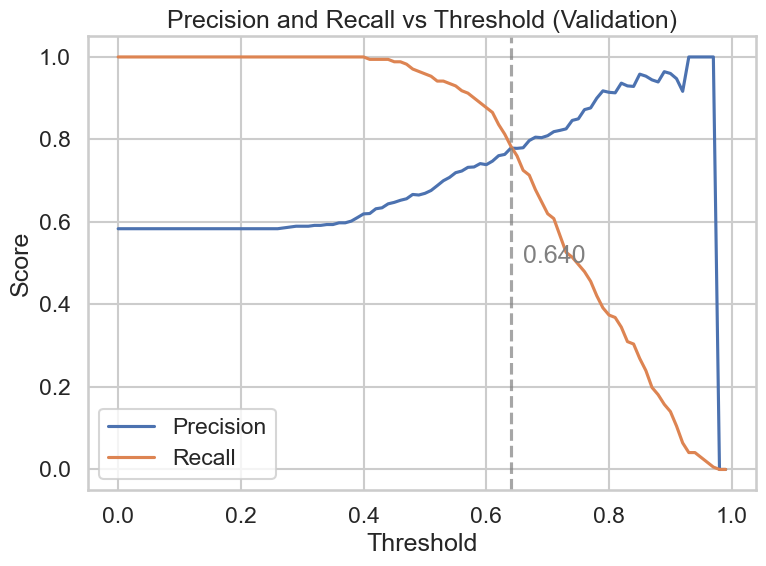

In [35]:
thresholds = np.arange(0.0, 1.0, 0.01)
precision = []
recall = []

for t in thresholds:
    preds = (y_pred >= t).astype(int)
    precision.append(precision_score(y_val, preds, zero_division=0))
    recall.append(recall_score(y_val, preds, zero_division=0))

precision = np.array(precision)
recall = np.array(recall)

diff = np.abs(precision - recall)
mask = thresholds <= 0.95
i_best = np.argmin(diff[mask])
best_threshold = thresholds[mask][i_best]
print(f"{best_threshold:.3f}")

sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(8, 6))
sns.lineplot(x=thresholds, y=precision, label="Precision")
sns.lineplot(x=thresholds, y=recall, label="Recall")
plt.axvline(best_threshold, color='gray', linestyle='--', alpha=0.7)
plt.text(float(best_threshold) + 0.02, 0.5, f"{best_threshold:.3f}", color='gray')

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold (Validation)")
plt.legend()
plt.tight_layout()
plt.show()

### Question 4: F1 score

In [36]:
f1 = 2 * precision * recall / (precision + recall + 1e-6)  # added a small number to avoid division by zero
best_idx = np.argmax(f1)
best_threshold = thresholds[best_idx]
best_f1 = f1[best_idx]
print(f"Best threshold for F1: {best_threshold:.2f}, F1={best_f1:.3f}")


Best threshold for F1: 0.57, F1=0.812


In [37]:
df_full_train

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
98,referral,NA,1,56659.0,employed,asia,4,0.75,1
1188,social_media,education,2,66171.0,unemployed,north_america,2,0.66,0
1407,events,finance,1,66523.0,self_employed,europe,3,0.64,1
1083,social_media,finance,1,56746.0,student,north_america,3,0.98,0
404,referral,NA,0,55449.0,student,australia,4,0.47,0
...,...,...,...,...,...,...,...,...,...
715,referral,NA,2,35103.0,unemployed,africa,0,0.88,0
905,social_media,other,1,66006.0,employed,south_america,5,0.64,1
1096,events,finance,2,73688.0,self_employed,asia,2,0.07,0
235,referral,technology,2,76723.0,employed,north_america,3,0.49,1


### Question 5 - CV Folds

In [38]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# to avoid data leakage, i impute using train set statistics only
def clean_numeric_impute(train_df: pd.DataFrame, val_df: pd.DataFrame):
    """Impute numerics with train medians; leave categoricals as strings (NaN->'NA')."""
    xtr, xva = train_df.copy(), val_df.copy()

    num_cols = xtr.select_dtypes(include=[np.number]).columns
    cat_cols = xtr.columns.difference(num_cols)

    for c in num_cols:
        xtr[c] = pd.to_numeric(xtr[c], errors="coerce").fillna(0.0)
        xva[c] = pd.to_numeric(xva[c], errors="coerce").fillna(0.0)

    for c in cat_cols:
        xtr[c] = xtr[c].astype("object").fillna("NA").astype(str)
        xva[c] = xva[c].astype("object").fillna("NA").astype(str)

    return xtr, xva

scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(df_full_train), start=1):
    df_tr = df_full_train.iloc[train_idx].reset_index(drop=True)
    df_va = df_full_train.iloc[val_idx].reset_index(drop=True)

    y_tr = df_tr[TARGET]
    y_va = df_va[TARGET]

    x_tr = df_tr.drop(columns=[TARGET])
    x_va = df_va.drop(columns=[TARGET])

    X_tr_c, X_va_c = clean_numeric_impute(x_tr, x_va)

    dv = DictVectorizer(sparse=False)
    x_tr_enc = dv.fit_transform(X_tr_c.to_dict(orient="records"))
    x_va_enc = dv.transform(X_va_c.to_dict(orient="records"))

    model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000)
    model.fit(x_tr_enc, y_tr)

    y_va_pred = model.predict_proba(x_va_enc)[:, 1]
    auc = roc_auc_score(y_va, y_va_pred)
    scores.append(auc)
    print(f"{fold}: AUC = {auc:.4f}")

mean_auc = float(np.mean(scores))
std_auc  = float(np.std(scores, ddof=1)) 
print(f"mean={mean_auc:.4f}, std={std_auc:.4f}")

1: AUC = 0.8061
2: AUC = 0.8714
3: AUC = 0.7754
4: AUC = 0.8018
5: AUC = 0.8558
mean=0.8221, std=0.0400


### Question 6 - CV Folds + Reg

In [40]:
c_values = [0.000001, 0.001, 1]
kf = KFold(n_splits=5, shuffle=True, random_state=1)

results = []

for C in c_values:
    scores = []
    for train_idx, val_idx in kf.split(df_full_train):
        df_tr = df_full_train.iloc[train_idx]
        df_va = df_full_train.iloc[val_idx]
        
        y_tr = df_tr[TARGET]
        y_va = df_va[TARGET]
        X_tr = df_tr.drop(columns=[TARGET])
        X_va = df_va.drop(columns=[TARGET])
        
        # Impute numeric 0, cat 'NA'
        X_tr = X_tr.fillna(0).astype(str)
        X_va = X_va.fillna(0).astype(str)
        
        dv = DictVectorizer(sparse=False)
        X_tr_enc = dv.fit_transform(X_tr.to_dict(orient="records"))
        X_va_enc = dv.transform(X_va.to_dict(orient="records"))
        
        model = LogisticRegression(solver="liblinear", C=C, max_iter=1000)
        model.fit(X_tr_enc, y_tr)
        
        y_pred = model.predict_proba(X_va_enc)[:, 1]
        auc = roc_auc_score(y_va, y_pred)
        scores.append(auc)
    
    mean_auc = round(np.mean(scores), 3)
    std_auc = round(np.std(scores), 3)
    results.append((C, mean_auc, std_auc))
    print(f"C={C}, mean={mean_auc}, std={std_auc}")


C=1e-06, mean=0.801, std=0.025
C=0.001, mean=0.816, std=0.023
C=1, mean=0.898, std=0.021
